# FW20 Breakout Trading System

## FW20 Futures

FW20 futures are standardized financial contracts traded on [the Warsaw Stock Exchange (GPW)](https://www.gpw.pl/en-home), where the underlying asset is the WIG20 index — a benchmark index representing the 20 largest companies on the Polish stock market.

### What Are FW20 Futures?

- FW20 stands for Futures on WIG20.
- These are cash-settled index futures, meaning there's no physical delivery of stocks—just a monetary settlement based on the index value.
- They allow investors to speculate, hedge, or gain leveraged exposure to the Polish equity market.

### Contract Specifications

- **Underlying asset**: WIG20 index
- **Multiplier**: 20 PLN per index point → If the contract is priced at 2,000 points, its nominal value is 40,000 PLN.
- **Settlement**: Cash only, no delivery of shares
- **Expiration months**: March, June, September, December (quarterly cycle)
- **Last trading day**: Third Friday of the expiration month (or the prior session if Friday is a holiday)

### Contract Symbol: FW20EYY20

- **F**: Futures contract
- **W20**: Underlying assest - WIG20 index
- **E**: Expiration month - H (March), M (June), U (September), Z (December)
- **YY**: Year of expiration
- **20**: Multiplier
- **Example**: FW20H2620 indicates futures contract expiring in June 2026

### How They’re Used

- **Speculation**: Traders bet on the direction of the WIG20 index.
- **Hedging**: Investors protect their portfolios against market downturns.
- **Arbitrage**: Exploit price differences between futures and spot markets.
- **Leverage**: Control a large position with relatively small capital.

### Risks

- Futures are highly leveraged, so small index movements can lead to large gains or losses.
- They require margin deposits and are marked-to-market daily.
- Not suitable for beginners without proper risk management.

### More Info

- [GPW's derivative page](https://www.gpw.pl/derivatives)
- [BOSSA's futures education section](https://bossa.pl/edukacja/kontrakty-opcje/kontrakty-terminowe/charakterystyka/kontrakty-na-indeksy) [PL version only]



## EDA

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [282]:
filepath = "data/fw20.csv"
df = pd.read_csv(filepath, parse_dates=['Date'])
df.set_index('Date', inplace=True) # Set 'Date' as the index
df.sort_index(inplace=True) # Ensure data is sorted by date

In [283]:
df.tail()

,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,
2025-09-25,2853,2856,2815,2825,20231,62808.0
2025-09-26,2828,2863,2813,2863,17378,65270.0
2025-09-29,2873,2880,2845,2859,13546,65238.0
2025-09-30,2854,2857,2830,2857,14266,66112.0
2025-10-01,2844,2885,2831,2878,18432,67739.0


In [284]:
df.isnull().sum()

Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    2
dtype: int64

In [285]:
df['Open Interest'] = df['Open Interest'].ffill()
df['Open Interest'] = df['Open Interest'].astype(int)

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6932 entries, 1998-01-20 to 2025-10-01
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open           6932 non-null   int64
 1   High           6932 non-null   int64
 2   Low            6932 non-null   int64
 3   Close          6932 non-null   int64
 4   Volume         6932 non-null   int64
 5   Open Interest  6932 non-null   int64
dtypes: int64(6)
memory usage: 379.1 KB


## Trading System

In [287]:
# Parameters
initial_capital = 10000  # Initial capital in CZK
short_window = 2
long_window = 14
signal_adj = 0.4

In [288]:
# calculate ATR


df['Prev_Close'] = df['Close'].shift(1).bfill().astype(int)
df['H-L'] = (df['High'] - df['Low']).astype(int)
df['H-PC'] = abs(df['High'] - df['Prev_Close']).astype(int)
df['L-PC'] = abs(df['Low'] - df['Prev_Close']).astype(int)
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR_short'] = df['TR'].rolling(window=short_window).mean()
df['ATR_long'] = df['TR'].rolling(window=long_window).mean()

In [289]:
# generate signals


df['Signal'] = (df['ATR_short'] * signal_adj).bfill().astype(int)
df['Buy_Level'] = (df['Open'] + df['Signal'].shift(1)).astype(float)
df['Sell_Level'] = (df['Open'] - df['Signal'].shift(1)).astype(float)

# Define entry conditions
df['Long_Entry'] = (df['High'] > df['Buy_Level']) & df['Buy_Level'].notna()
df['Short_Entry'] = (df['Low'] < df['Sell_Level']) & df['Sell_Level'].notna()

# --- Simulate Trades ---
# Initialize position: 1 = long, -1 = short, 0 = flat
position = []
entry_price = []
current_pos = 0  # 1 = long, -1 = short, 0 = flat
last_entry = np.nan

for i in range(len(df)):
    long_signal = df['Long_Entry'].iloc[i]
    short_signal = df['Short_Entry'].iloc[i]

    if current_pos == 0:
        if long_signal:
            current_pos = 1
            last_entry = df['Buy_Level'].iloc[i]
        elif short_signal:
            current_pos = -1
            last_entry = df['Sell_Level'].iloc[i]

    elif current_pos == 1:
        if short_signal:
            current_pos = -1
            last_entry = df['Sell_Level'].iloc[i]

    elif current_pos == -1:
        if long_signal:
            current_pos = 1
            last_entry = df['Buy_Level'].iloc[i]

    position.append(current_pos)
    entry_price.append(last_entry)

df['Position'] = position
df['Entry_Price'] = entry_price

In [290]:
# --- Calculate result in points ---
# Create columns to store results
df['Daily_pts'] = np.nan  # Actual PnL on the entry day (close - entry)

# Loop through rows
for i in range(1, len(df)):
    prev_pos = df['Position'].iloc[i - 1]
    curr_pos = df['Position'].iloc[i]
    curr_close = df['Close'].iloc[i]
    prev_close = df['Close'].iloc[i - 1]
    entry_price = df['Entry_Price'].iloc[i]

     # Case 1: Position flipped (e.g. Long → Short or Short → Long)
    if curr_pos != prev_pos and curr_pos != 0:
        df.at[df.index[i], 'Daily_pts'] = ((entry_price - prev_close) * prev_pos) + ((curr_close - entry_price) * curr_pos)

    # Case 2: New position opened from flat
    elif prev_pos == 0 and curr_pos != 0:
        df.at[df.index[i], 'Daily_pts'] = (curr_close - entry_price) * curr_pos

    # Case 3: Holding position
    elif curr_pos == prev_pos and curr_pos != 0 and prev_pos != 0:
        df.at[df.index[i], 'Daily_pts'] = (curr_close - prev_close) * curr_pos

# Calculate cumulative PnL
df['Cumulative_pts'] = df['Daily_pts'].cumsum()


In [304]:
# --- Calculate PnL ---
df['Daily_PnL'] = df['Daily_pts'] * 20  # Each point is worth 20 CZK
df['Cumulative_PnL'] = df['Daily_PnL'].cumsum() + initial_capital

In [307]:
# --- Calculate Drawdown ---
df['Cumulative_Max'] = df['Cumulative_PnL'].cummax()
df['Drawdown'] = df['Cumulative_PnL'] - df['Cumulative_Max']
df['Drawdown_Pct'] = df['Drawdown'] / df['Cumulative_Max'].replace(0, np.nan)
max_drawdown = df['Drawdown'].min()
max_drawdown_pct = df['Drawdown_Pct'].min()
print(f"Max Drawdown: {max_drawdown}, Max Drawdown %: {max_drawdown_pct}")

Max Drawdown: -16720.0, Max Drawdown %: -0.24489795918367346


In [310]:
df.head(20)

,Open,High,Low,Close,Volume,Open Interest,Prev_Close,H-L,H-PC,L-PC,...,Short_Entry,Position,Entry_Price,Daily_pts,Cumulative_pts,Daily_PnL,Cumulative_PnL,Cumulative_Max,Drawdown,Drawdown_Pct
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-20,1440,1440,1440,1440,4,12,1440,0,0,0,...,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-22,1370,1370,1370,1370,9,21,1440,0,70,70,...,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-23,1370,1370,1370,1370,2,22,1370,0,0,0,...,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-28,1382,1390,1382,1389,8,9,1370,8,20,12,...,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-29,1417,1417,1412,1412,4,21,1389,5,28,23,...,True,-1,1413.0,1.0,1.0,20.0,10020.0,10020.0,0.0,0.000000
1998-01-30,1410,1410,1380,1380,2,9,1412,30,2,32,...,True,-1,1413.0,32.0,33.0,640.0,10660.0,10660.0,0.0,0.000000
1998-02-02,1433,1485,1433,1485,22,25,1380,52,105,53,...,False,1,1445.0,-25.0,8.0,-500.0,10160.0,10660.0,-500.0,-0.046904
1998-02-03,1507,1551,1507,1543,15,26,1485,44,66,22,...,False,1,1445.0,58.0,66.0,1160.0,11320.0,11320.0,0.0,0.000000
1998-02-04,1490,1504,1490,1504,3,9,1543,14,39,53,...,False,1,1445.0,-39.0,27.0,-780.0,10540.0,11320.0,-780.0,-0.068905


In [308]:
df.tail(20)

,Open,High,Low,Close,Volume,Open Interest,Prev_Close,H-L,H-PC,L-PC,...,Short_Entry,Position,Entry_Price,Daily_pts,Cumulative_pts,Daily_PnL,Cumulative_PnL,Cumulative_Max,Drawdown,Drawdown_Pct
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-04,2797,2842,2764,2833,24875,57367,2790,78,52,26,...,True,1,2817.0,-11.0,22462.0,-220.0,459240.0,462800.0,-3560.0,-0.007692
2025-09-05,2849,2865,2808,2810,23959,57246,2833,57,32,25,...,True,-1,2826.0,9.0,22471.0,180.0,459420.0,462800.0,-3380.0,-0.007303
2025-09-08,2822,2871,2814,2870,21896,61004,2810,57,61,4,...,False,1,2849.0,-18.0,22453.0,-360.0,459060.0,462800.0,-3740.0,-0.008081
2025-09-09,2862,2875,2829,2841,17960,60051,2870,46,5,41,...,True,-1,2839.0,-33.0,22420.0,-660.0,458400.0,462800.0,-4400.0,-0.009507
2025-09-10,2828,2834,2765,2815,32271,62040,2841,69,7,76,...,True,-1,2839.0,26.0,22446.0,520.0,458920.0,462800.0,-3880.0,-0.008384
2025-09-11,2820,2871,2813,2860,24888,66275,2815,58,56,2,...,False,1,2844.0,-13.0,22433.0,-260.0,458660.0,462800.0,-4140.0,-0.008946
2025-09-12,2864,2874,2836,2838,23822,65553,2860,38,14,24,...,True,-1,2838.0,-22.0,22411.0,-440.0,458220.0,462800.0,-4580.0,-0.009896
2025-09-15,2848,2871,2844,2865,61591,68557,2838,27,33,6,...,False,1,2867.0,-31.0,22380.0,-620.0,457600.0,462800.0,-5200.0,-0.011236
2025-09-16,2874,2881,2817,2825,66208,69347,2865,64,16,48,...,True,-1,2860.0,30.0,22410.0,600.0,458200.0,462800.0,-4600.0,-0.009939


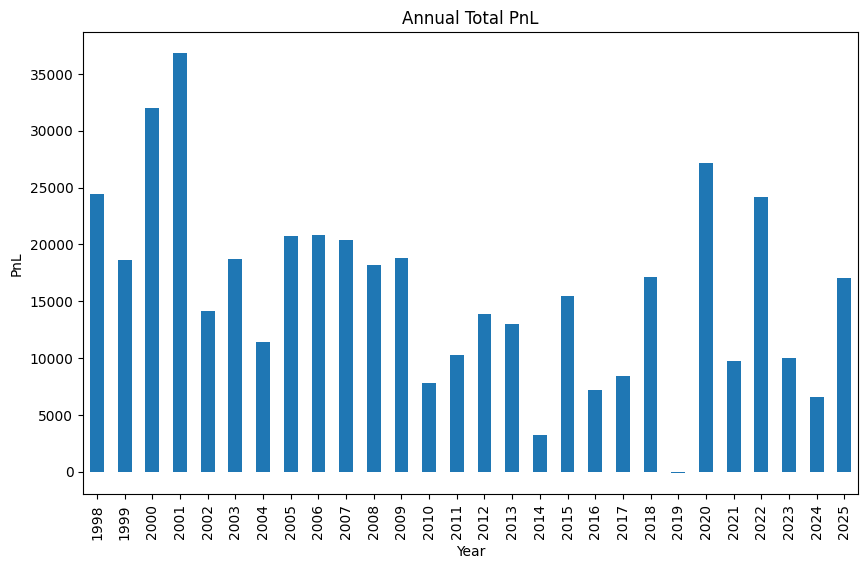

In [295]:
df['Daily_PnL'].groupby(df.index.year).sum().plot(kind='bar', title='Annual Total PnL', figsize=(10, 6))
plt.ylabel('PnL')
plt.xlabel('Year')
plt.show()

In [311]:
df['Daily_PnL'].groupby(df.index.year).sum().mean()

np.float64(15932.142857142857)

Text(0, 0.5, 'Cumulative PnL')

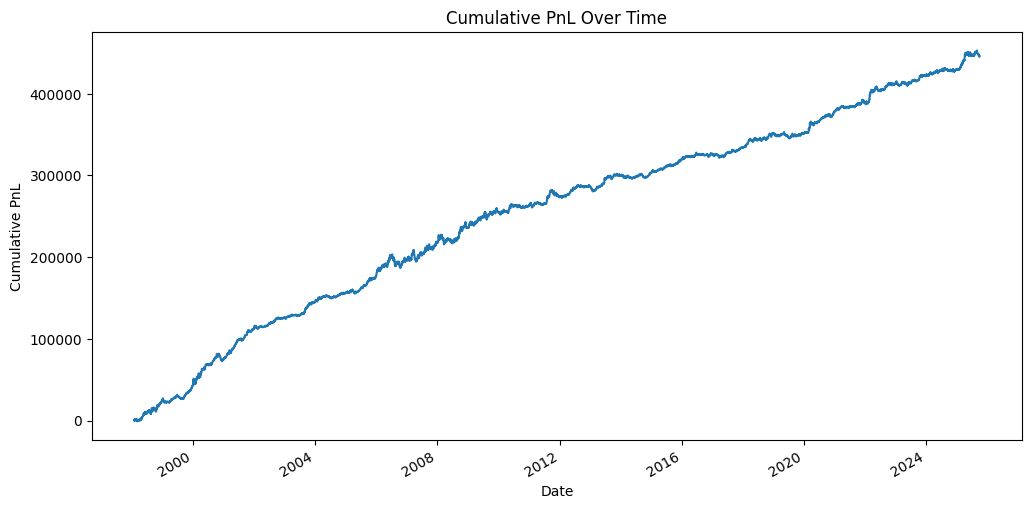

In [296]:
df['Cumulative_PnL'].plot(title='Cumulative PnL Over Time', figsize=(12, 6))
plt.ylabel('Cumulative PnL')

Text(0, 0.5, 'Drawdown (CZK)')

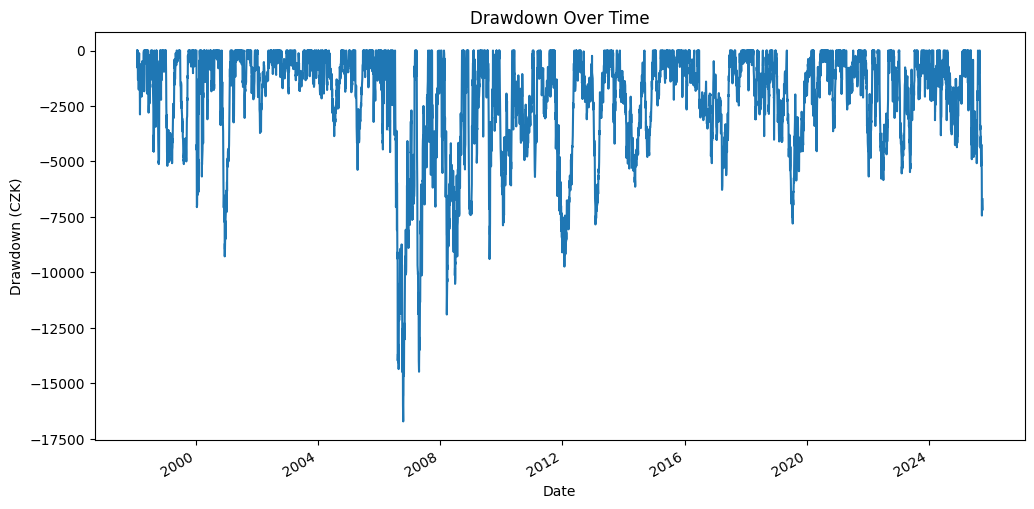

In [312]:
df['Drawdown'].plot(title='Drawdown Over Time', figsize=(12, 6))
plt.ylabel('Drawdown (CZK)')

Text(0, 0.5, 'Drawdown Percentage (%)')

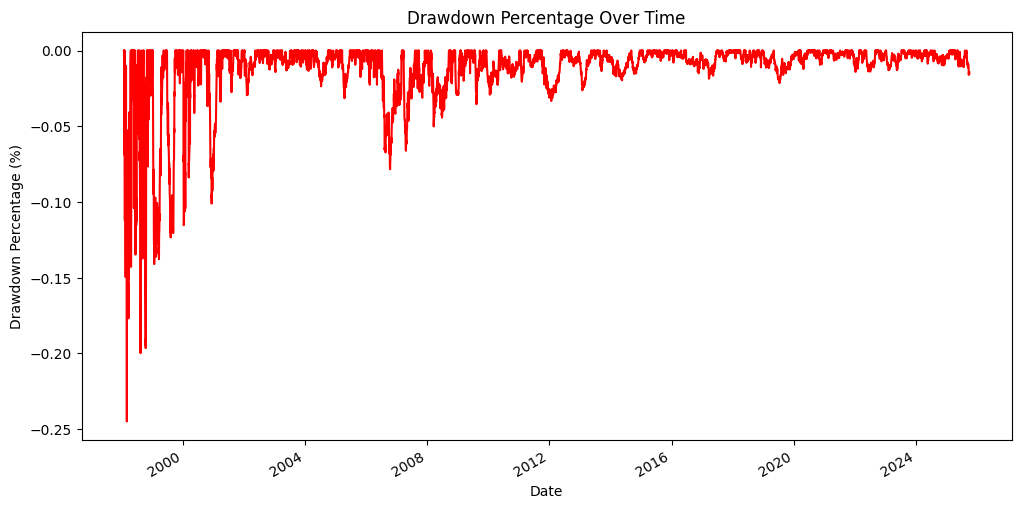

In [313]:
df['Drawdown_Pct'].plot(title='Drawdown Percentage Over Time', figsize=(12, 6), color='red')
plt.ylabel('Drawdown Percentage (%)')